# Introduction
## What we are trying to accomplish
In general we are trying to provide answers to the following questions:
- How is the adoption of renewable energy in Europe evolving?
- How is the adoption of different types of renewable energy evolving?
- Are there characteristics of countries that correlate with their level of adoption of renewable energy?

### Main Questions
As these questions are defined very broadly and can be answered in a variety of ways, we decided to formulate the following more discreet questions, focusing on the production and consumption of renewable energy in europe:
- How has the adoption of renewable energy in Europe developed over time?
- Which types of renewable energy have been predominantly adopted?

### Sub Questions
- How do economic factors like GDP influence the adoption of renewable energy?
- How does austria compare to the european average?


## Data Description
We are using the dataset from [Kaggle](https://www.kaggle.com/datasets/programmerrdai/renewable-energy/data). The general description can be found at the original [ourworldindata.org](https://ourworldindata.org/grapher/installed-solar-pv-capacity#:~:text=IRENA%20%E2%80%93%20Renewable%20Capacity-,Statistics) data source.
**Absolute Values:** Absolute measurements are represented in megawatts (MW) rounded to the nearest one megawatt, with figures between zero and 0.5MW shown as a 0.
**Shares:** Shares are represented as percentages

## Exploring the data
### Main data sources
Load all required packages and modules

In [99]:
import glob
import os
import pickle
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg.linalg import LinAlgError
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

The dataset contains a wide range of data from different countries and time ranges. In this exercise we chose to only consider **european** countries and compare them to the overall european and global trends. We take the **years (1990-2020)** into consideration to answer our questions.

In [100]:
# ISO codes for European countries
country_codes_main_data = (
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
    'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT',
    'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'GBR')
entities = ('Europe', 'World')
time_window = (1980, 2020)

We clean the data by:
- Removing all non-European countries
- Only consider our targeted time window (1990-2020)

In [101]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    # Only Use European Countries & Europe/World accumulated data
    df = df[(df['Code'].isin(country_codes_main_data)) | (df['Entity'].isin(entities))]

    if 'Year' in df.columns:
        df.loc[:, 'Year'] = pd.to_numeric(df['Year'], errors='coerce')
        df = df[(df['Year'] >= time_window[0]) & (df['Year'] <= time_window[1])]


    # Remove 'Code' Column, as it is redundant
    df.drop(columns=['Code'], inplace=True)

    df.reset_index(drop=True, inplace=True)

    return df

Put it all together and read and clean the dataframes:

In [102]:
def read_and_clean_csv(file) -> pd.DataFrame:
    df = pd.read_csv(file)
    df = clean_df(df)
    return df

folder_path_main_data = os.path.join('..', 'data')
csv_files = glob.glob(os.path.join(folder_path_main_data, '*.csv'))

dataframes = {os.path.basename(file).split('.')[0]: read_and_clean_csv(file) for file in csv_files}

#### Merge semantically relevant dataframes
Now we merge dataframes that contain semantically relevant data into one. These are:
- `share_energy:` merged from `hydro-share-energy`,`solar-share-energy`,`wind-share-energy`,`renewable-share-energy`
- `share_electricity:` merged from `share-electricity-hydro`,`share-electricity-solar`,`share-electricity-solar`,`share-electricity-wind`,`share-electricity-renewables`
- `energy_consumption_electricity_production:` merged from `modern-renewable-prod`, `modern-renewable-energy-consumption`



In [103]:
def merge_share_dfs(dfs: dict[str: pd.DataFrame], sub_str: str) -> pd.DataFrame:
    relevant_keys = [key for key in dfs.keys() if sub_str in key]
    filtered_dfs = dfs[relevant_keys[0]]
    for key in relevant_keys[1:]:
        filtered_dfs = filtered_dfs.merge(
            dfs[key],
            on=['Entity', 'Year'],
            how='outer'
        )
    return filtered_dfs

def merge_production_consumption(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df1, df2,
                  on=['Entity', 'Year'],
                  how='outer'
                  )
    return df

Let's start off by merging the overall share percentages.

In [104]:
share_energy_long = merge_share_dfs(dataframes, 'share-energy')
share_electricity_long = merge_share_dfs(dataframes, 'share-electricity')
installed_capacity_long = merge_share_dfs(dataframes, 'capacity')

Add new columns based on already existing data.

In [105]:
share_energy_long['Other Renewables (% sub energy)'] = share_energy_long['Renewables (% sub energy)'] - ((share_energy_long['Solar (% sub energy)']) + (share_energy_long['Hydro (% sub energy)']) + (share_energy_long['Wind (% sub energy)']))
share_electricity_long['Other Renewables (% electricity)'] = share_electricity_long['Renewables (% electricity)'] - ((share_electricity_long['Solar (% electricity)']) + (share_electricity_long['Hydro (% electricity)']) + (share_electricity_long['Wind (% electricity)']))

installed_capacity_long['Total Capacity'] = installed_capacity_long['Wind Capacity'].fillna(0) + installed_capacity_long['Geothermal Capacity'].fillna(0) + installed_capacity_long['Solar Capacity'].fillna(0)

Now let's finish by merging the absolute values for production/consumption.

In [106]:
electricity_production_long = dataframes['modern-renewable-prod']
electricity_production_long = electricity_production_long.rename(columns=
                                                       {
                                                           'Electricity from wind (TWh)': 'Electricity production wind (TWh)',
                                                           'Electricity from hydro (TWh)': 'Electricity production hydro (TWh)',
                                                           'Electricity from solar (TWh)': 'Electricity production solar (TWh)',
                                                           'Electricity from other renewables including bioenergy (TWh)': 'Electricity production other renewables including bioenergy (TWh)'
                                                        })

energy_consumption_long = dataframes['modern-renewable-energy-consumption']
energy_consumption_long = energy_consumption_long.rename(columns=
                                                       {
                                                           'Wind Generation - TWh': 'Wind consumption (TWh)',
                                                           'Solar Generation - TWh': 'Solar consumption (TWh)',
                                                           'Geo Biomass Other - TWh': 'Other renewable consumption (TWh)',
                                                           'Hydro Generation - TWh': 'Hydro consumption (TWh)',
                                                        })

energy_consumption_electricity_production_long = merge_production_consumption(energy_consumption_long, electricity_production_long)

#### Multi-Index
These newly merged frames can now be converted from a long format to a wide multi-index dataformat.

In [107]:
share_energy = share_energy_long.set_index(['Entity', 'Year'])
share_electricity = share_electricity_long.set_index(['Entity','Year'])
installed_capacity = installed_capacity_long.set_index(['Entity', 'Year'])
energy_consumption_electricity_production = energy_consumption_electricity_production_long.set_index(['Entity', 'Year'])

### Secondary Data Sources
In order to make reasonable assumptions, we include some additional external data sources for:
- GDP per capita (USD)
- Electricity Prices (EUR/kWh)



In [108]:
folder_path_secondary_data = os.path.join('..', 'secondary-data')

Let's start with the GDP per capita.

In [109]:
def melt_gdp_year_columns(df: pd.DataFrame) -> pd.DataFrame:
    df_melted = df.melt(
        id_vars=["Entity", "Code"],  # Keep these columns as they are
        var_name="Year",                   # New column name for years
        value_name="GDP per capita (USD)"                 # New column name for values
    )

    # Convert the 'Year' column to numeric, ignoring non-numeric entries
    df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors="coerce")

    # Drop rows where 'Year' or 'Value' is NaN
    df_melted = df_melted.dropna(subset=["Year", "GDP per capita (USD)"]).reset_index(drop=True)

    df_melted["Year"] = df_melted["Year"].astype(int)

    return df_melted

In [110]:
# GDP per capita (USD)
gdp_per_capita_csv_file = os.path.join(folder_path_secondary_data, 'gdp_per_capita.csv')
gdp_per_capita_original = pd.read_csv(gdp_per_capita_csv_file)
gdp_per_capita_long = melt_gdp_year_columns(gdp_per_capita_original)
gdp_per_capita_long = clean_df(gdp_per_capita_long)

Now we take a look at the electricity prices. Because this is an external dataset, we cannot simply use the same time frame we have set for our primary data. This dataset only contains values from 2007 onward.

In [111]:
country_code_to_name_electricity_price_data = {
    'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'HR': 'Croatia',
    'CY': 'Cyprus', 'CZ': 'Czechia', 'DK': 'Denmark', 'EE': 'Estonia',
    'FI': 'Finland', 'FR': 'France', 'DE': 'Germany', 'EL': 'Greece',
    'HU': 'Hungary', 'IS': 'Iceland', 'IE': 'Ireland', 'IT': 'Italy',
    'LV': 'Latvia', 'LT': 'Lithuania', 'LU': 'Luxembourg', 'NL': 'Netherlands',
    'NO': 'Norway', 'PL': 'Poland', 'PT': 'Portugal', 'RO': 'Romania',
    'SK': 'Slovakia', 'SI': 'Slovenia', 'ES': 'Spain', 'SE': 'Sweden',
    'CH': 'Switzerland', 'UK': 'United Kingdom'
}

# TODO check if we should just cut off at year 2020
time_window_electricity_price = (2007, 2025)

# Filter for the selected countries
selected_country_codes = set(country_code_to_name_electricity_price_data.keys())

In [112]:
def clean_numeric_values(val):
    """
    Function ensures numeric conversion for time columns
    :param val:
    :return:
    """
    if isinstance(val, str):
        return re.sub(r'[^\d.-]', '', val.strip())  # Remove non-numeric characters and strip spaces
    return val

def clean_electricity_price_df(df: pd.DataFrame) -> pd.DataFrame:
    # Strip whitespace from column names
    df.columns = [col.strip() for col in df.columns]

    # Extract the first column name dynamically
    first_column_name = df.columns[0]

    # Extract the country code from the first column
    df['Entity'] = df[first_column_name].str.split(',').str[-1].str.strip()
    df.drop(columns=[first_column_name], inplace=True)

    # Identify time-based columns (e.g., 2007-S1)
    time_columns = [col for col in df.columns if re.match(r'\d{4}-S\d', col)]

    # Clean time columns and convert to numeric
    #df[time_columns] = df[time_columns].applymap(clean_numeric_values).apply(pd.to_numeric, errors='coerce')
    # Assuming time_columns is a list of columns to clean
    df[time_columns] = df[time_columns].apply(lambda col: col.map(clean_numeric_values).apply(pd.to_numeric, errors='coerce'))


    # Deduplicate by country code
    df = df.drop_duplicates(subset=['Entity'])

    filtered_data = df[df['Entity'].isin(selected_country_codes)]

    return filtered_data

def convert_electricity_price_to_annual_means(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate annual means (average of S1-S4 per year)
    annual_means = {}
    for year in range(time_window_electricity_price[0], time_window_electricity_price[1]):
        semesters = [f"{year}-S{semester}" for semester in range(1, 5)]
        available_semesters = [sem for sem in semesters if sem in df.columns]
        if available_semesters:
            annual_means[year] = df[available_semesters].mean(axis=1, skipna=True)

    # Create a DataFrame for annual means
    annual_means_df = pd.DataFrame(annual_means)
    annual_means_df.index = df['Entity']

    return annual_means_df

def read_clean_convert_electricity_prices(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, sep='\t')
    df = clean_electricity_price_df(df)
    df = convert_electricity_price_to_annual_means(df)
    return df


In [113]:
household_electricity_csv_file = os.path.join(folder_path_secondary_data, 'estat_nrg_pc_204.tsv')
non_household_electricity_csv_file = os.path.join(folder_path_secondary_data, 'estat_nrg_pc_205.tsv')

household_electricity = read_clean_convert_electricity_prices(household_electricity_csv_file)
non_household_electricity = read_clean_convert_electricity_prices(non_household_electricity_csv_file)

# Align both DataFrames by their indices (countries) and columns (years)
combined_data = (household_electricity + non_household_electricity) / 2

# Map country codes to their full names for better visualization
combined_data.index = combined_data.index.map(
    {k: v for k, v in country_code_to_name_electricity_price_data.items()}
)

In [114]:
def melt_electricity_price_year_column(df: pd.DataFrame) -> pd.DataFrame:
    df_melted = df.reset_index()
    df_melted = df_melted.melt(
        id_vars=["Entity"],  # Keep these columns as they are
        var_name="Year",                   # New column name for years
        value_name="electricity price per kWh"                 # New column name for values
    )

    # Convert the 'Year' column to numeric, ignoring non-numeric entries
    df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors="coerce")

    # Drop rows where 'Year' or 'Value' is NaN
    df_melted = df_melted.dropna(subset=["Year", "electricity price per kWh"]).reset_index(drop=True)

    df_melted["Year"] = df_melted["Year"].astype(int)

    return df_melted

In [115]:
electricity_price_data_long = melt_electricity_price_year_column(combined_data)

#### Multi-Index

In [116]:
gdp_per_capita = gdp_per_capita_long.set_index(['Entity', 'Year']).sort_index()
electricity_price_data = electricity_price_data_long.set_index(['Entity', 'Year']).sort_index()

### Noticing Trends
Now let's create some plots in order to better observe certain trends

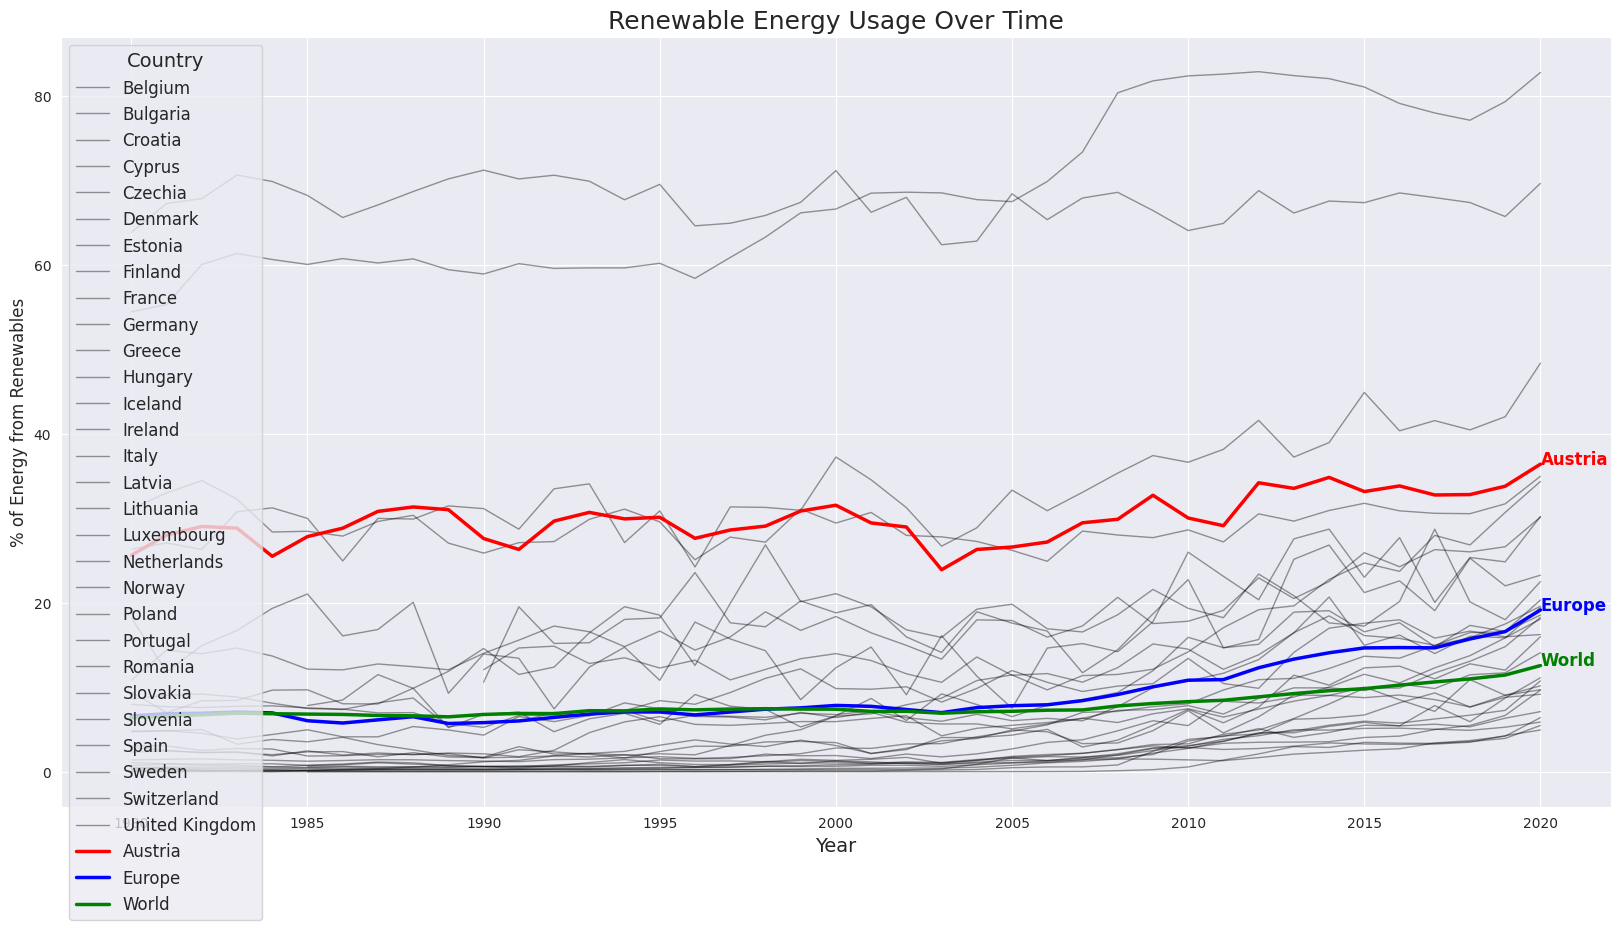

In [117]:
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Define standout countries
standout_countries = ['Austria', 'Europe', 'World']

# Create a custom color palette
palette = {country: 'black' for country in data_filtered['Entity'].unique()}
palette.update({
    'Austria': 'red',
    'Europe': 'blue',
    'World': 'green'
})

# Plot
plt.figure(figsize=(20, 10))

# Plot all countries with lighter lines
sns.lineplot(
    data=data_filtered[~data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, alpha=0.4, linewidth=1
)

# Plot standout countries with distinctive styles
sns.lineplot(
    data=data_filtered[data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, linewidth=2.5
)

# Add titles and labels
plt.title('Renewable Energy Usage Over Time', fontsize=18)
plt.ylabel('% of Energy from Renewables', fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.legend(title='Country', fontsize=12, title_fontsize=14)
plt.grid(True)

# Highlight lines with direct annotations
for country in standout_countries:
    country_data = data_filtered[data_filtered['Entity'] == country]
    plt.text(
        country_data['Year'].iloc[-1],
        country_data['Renewables (% sub energy)'].iloc[-1],
        country,
        color=palette[country], fontsize=12, weight='bold'
    )

plt.show()

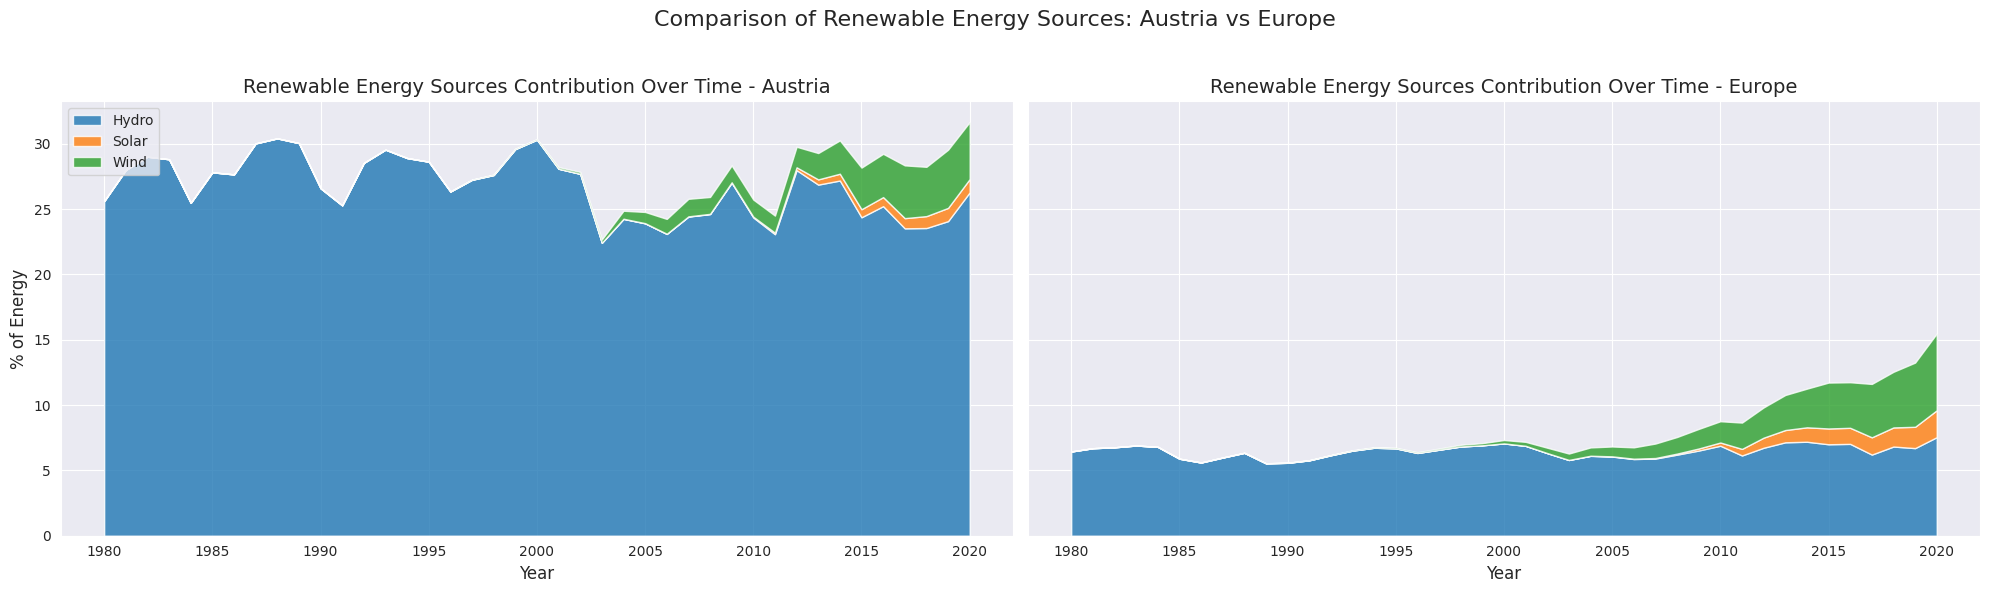

In [118]:
# Select data for Austria
country_austria = 'Austria'
data_austria = share_energy.loc[country_austria].reset_index()

# Select data for Europe
country_europe = 'Europe'
data_europe = share_energy.loc[country_europe].reset_index()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot for Austria
axes[0].stackplot(
    data_austria['Year'],
    data_austria['Hydro (% sub energy)'],
    data_austria['Solar (% sub energy)'],
    data_austria['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[0].set_title(f'Renewable Energy Sources Contribution Over Time - {country_austria}', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('% of Energy', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot for Europe
axes[1].stackplot(
    data_europe['Year'],
    data_europe['Hydro (% sub energy)'],
    data_europe['Solar (% sub energy)'],
    data_europe['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[1].set_title(f'Renewable Energy Sources Contribution Over Time - {country_europe}', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(True)

# Adjust layout
plt.suptitle('Comparison of Renewable Energy Sources: Austria vs Europe', fontsize=16)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

Even though we only have specific data for Hydro, Solar and Wing generation, there other renewable ways of generating energy. To show how much data we are missing on other renewable energy types, we plotted the most recent (2020) energy usage.

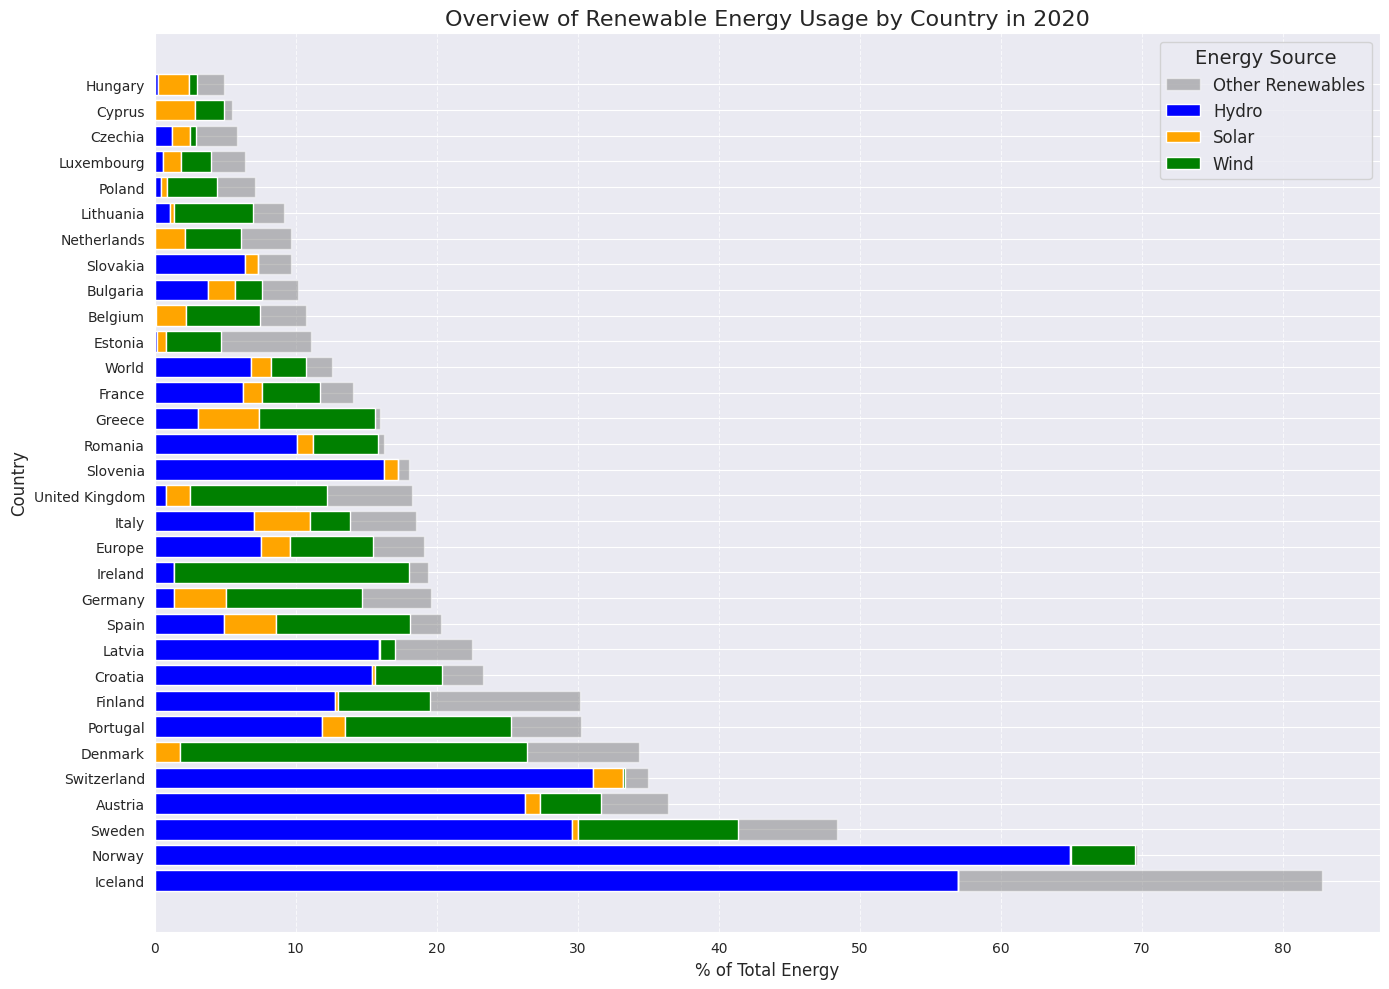

In [119]:
# Filter the data for the year 2020
data_2020 = share_energy.xs(key=2020, level='Year')

# Sort by total renewables for better visualization
data_2020 = data_2020.sort_values(by='Renewables (% sub energy)', ascending=False)

# Create a stacked bar plot
plt.figure(figsize=(14, 10))

# Plot the total renewable energy as a separate bar beforehand
# This makes it show up as the other types of renewable energy that we are missing (e.g. not in hydro, wind, solar)
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Renewables (% sub energy)'], label='Other Renewables', color='gray', alpha=0.5)

# Plot the stacked bars for Hydro, Solar, and Wind
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Solar (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'],
    label='Solar',
    color='orange'
)
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Wind (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'] + data_2020['Solar (% sub energy)'],
    label='Wind',
    color='green'
)

# Add labels and title
plt.title('Overview of Renewable Energy Usage by Country in 2020', fontsize=16)
plt.xlabel('% of Total Energy', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Energy Source', fontsize=12, title_fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

## Which types of renewable energy have been predominantly adopted?
Plot how the percentage of renewable energy from different sources (Hydro, Solar, Wind, and Other Renewables) has changed globally, to get an overall view.

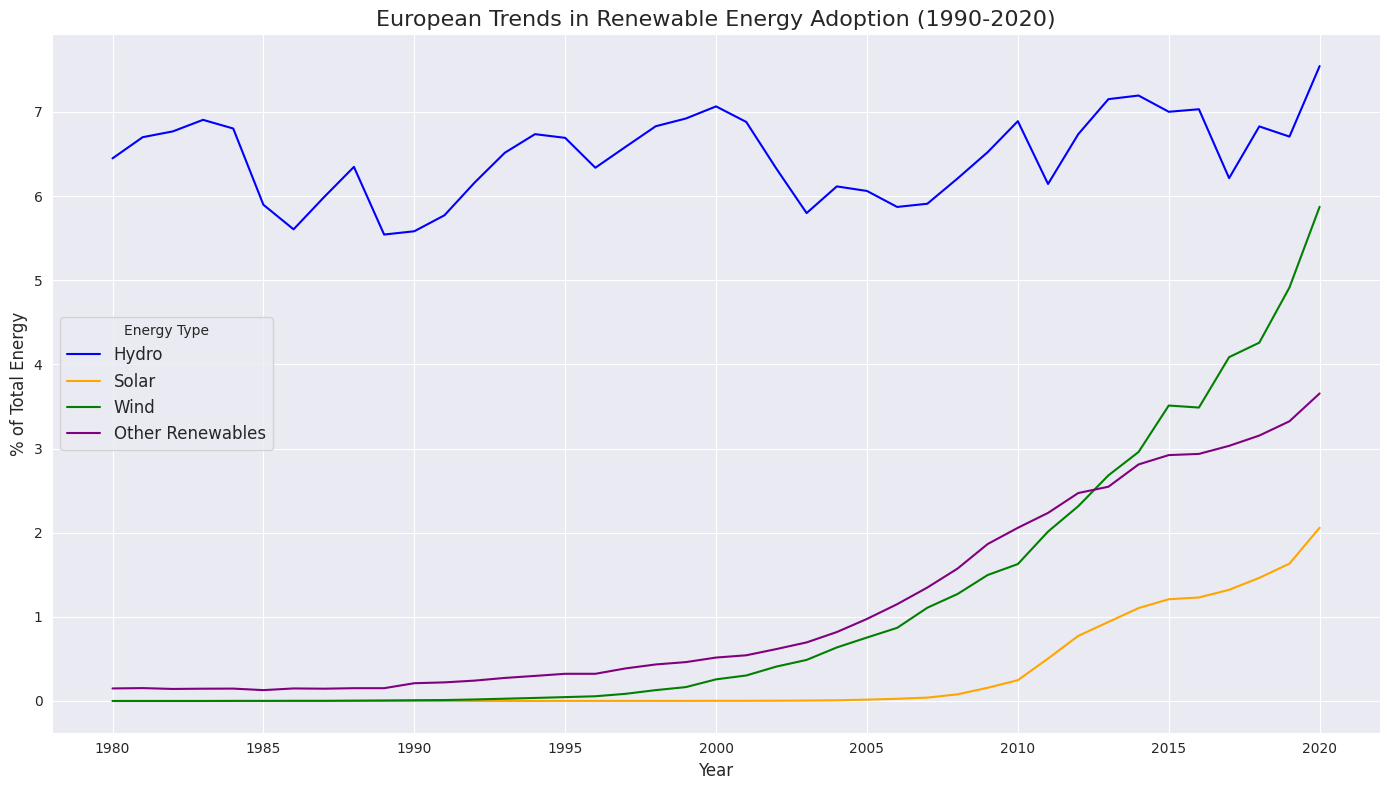

In [120]:
# Filter for global data (use 'World' as the entity)
share_energy_europe = share_energy.xs(key='Europe', level='Entity')

# TODO replace with seaborn
# Plot trends in renewable energy types (Hydro, Solar, Wind, Other Renewables) globally
plt.figure(figsize=(14, 8))
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Solar (% sub energy)'], label='Solar', color='orange')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Wind (% sub energy)'], label='Wind', color='green')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Other Renewables (% sub energy)'], label='Other Renewables', color='purple')

plt.title('European Trends in Renewable Energy Adoption (1990-2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('% of Total Energy', fontsize=12)
plt.legend(title='Energy Type', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Determine the dominant renewable energy source by calculating the mean share for each source over time

In [121]:
# Calculate the average percentage of each renewable energy type globally over time
mean_renewables = share_energy_europe[['Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']].mean()

# Sort to identify the most dominant energy type
mean_renewables_sorted = mean_renewables.sort_values(ascending=False)

# Print the result
print(f"Most Predominantly Adopted Renewable Energy Types (Mean over Time):\n{mean_renewables_sorted}")

Most Predominantly Adopted Renewable Energy Types (Mean over Time):
Hydro (% sub energy)               6.471561
Wind (% sub energy)                1.119829
Other Renewables (% sub energy)    1.119195
Solar (% sub energy)               0.312780
dtype: float64


Another interesting analysis is to see which year had the highest adoption of each energy source.

In [122]:
# Find the year with the highest percentage for each renewable energy type globally
max_renewables_year = share_energy_europe[['Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']].idxmax()

# Print the results
print(f"Year with the highest adoption of each renewable energy type:\n{max_renewables_year}")

Year with the highest adoption of each renewable energy type:
Hydro (% sub energy)               2020
Solar (% sub energy)               2020
Wind (% sub energy)                2020
Other Renewables (% sub energy)    2020
dtype: int64


#### Renewable Energy capacity

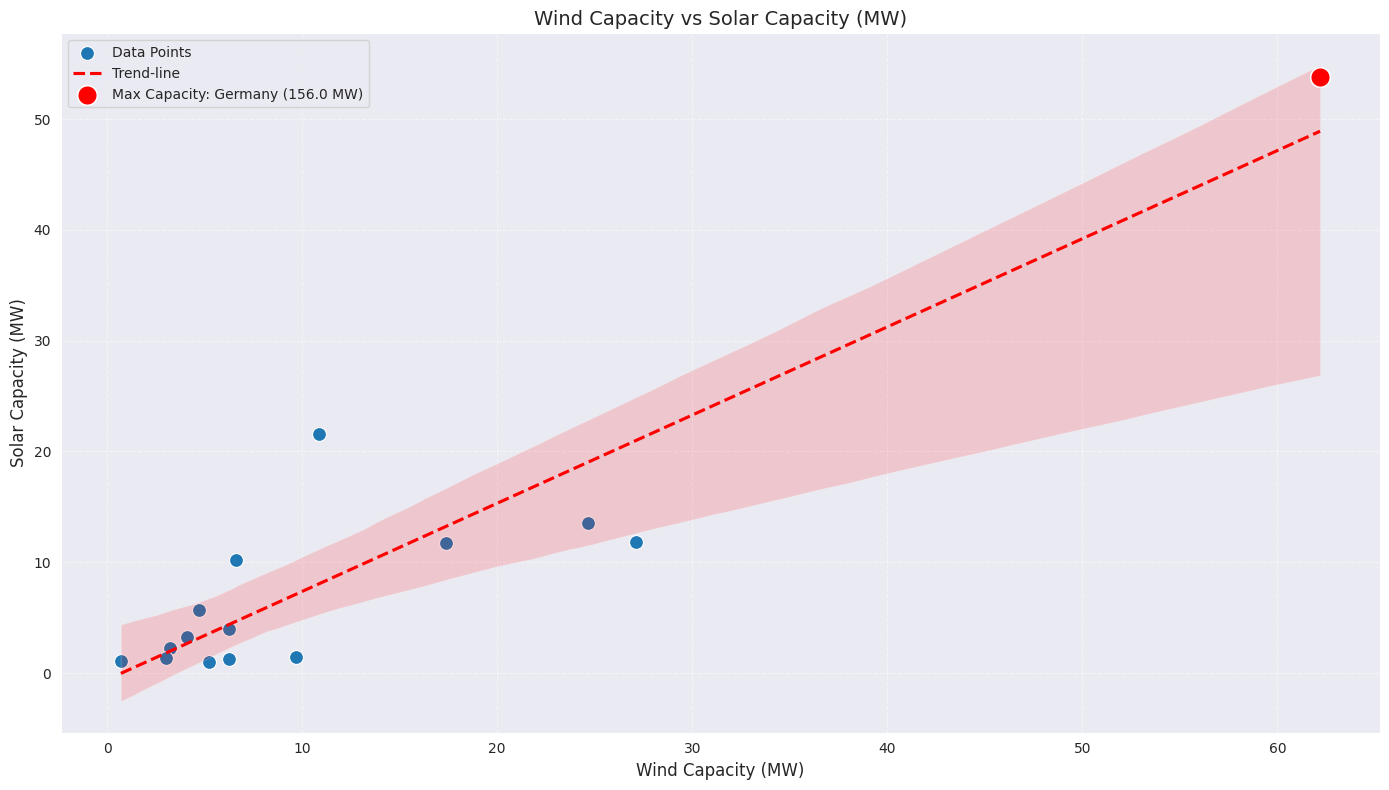

In [123]:
installed_capacity_2020 = installed_capacity.xs(key=2020, level='Year')
# Exclude non-country entities:
installed_capacity_2020_countries_only = installed_capacity_2020[~installed_capacity_2020.index.get_level_values("Entity").isin(["World", "Europe"])].copy()
installed_capacity_2020_countries_only["Solar+Wind Capacity"] = (
    installed_capacity_2020_countries_only["Wind Capacity"].fillna(0) +
    installed_capacity_2020_countries_only["Solar Capacity"].fillna(0)
)

# Identify the entity with the maximum total capacity
max_entity = installed_capacity_2020_countries_only["Solar+Wind Capacity"].idxmax()
max_capacity = installed_capacity_2020_countries_only.loc[max_entity]

installed_capacity_2020_countries_only_reset = installed_capacity_2020_countries_only.reset_index()

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=installed_capacity_2020_countries_only_reset,
    x="Wind Capacity",
    y="Solar Capacity",
    s=100,
    label="Data Points",
)

sns.regplot(
    data=installed_capacity_2020_countries_only_reset,
    x="Wind Capacity",
    y="Solar Capacity",
    scatter=False,
    color="red",
    label="Trend-line",
    line_kws={"linestyle": "--"},
)

# Highlight the point with the highest capacity
sns.scatterplot(
    x=[max_capacity["Wind Capacity"]],
    y=[max_capacity["Solar Capacity"]],
    color="red",
    s=200,
    label=f"Max Capacity: {max_entity} ({max_capacity['Total Capacity']:.1f} MW)",
)

plt.title("Wind Capacity vs Solar Capacity (MW)", fontsize=14)
plt.xlabel("Wind Capacity (MW)", fontsize=12)
plt.ylabel("Solar Capacity (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

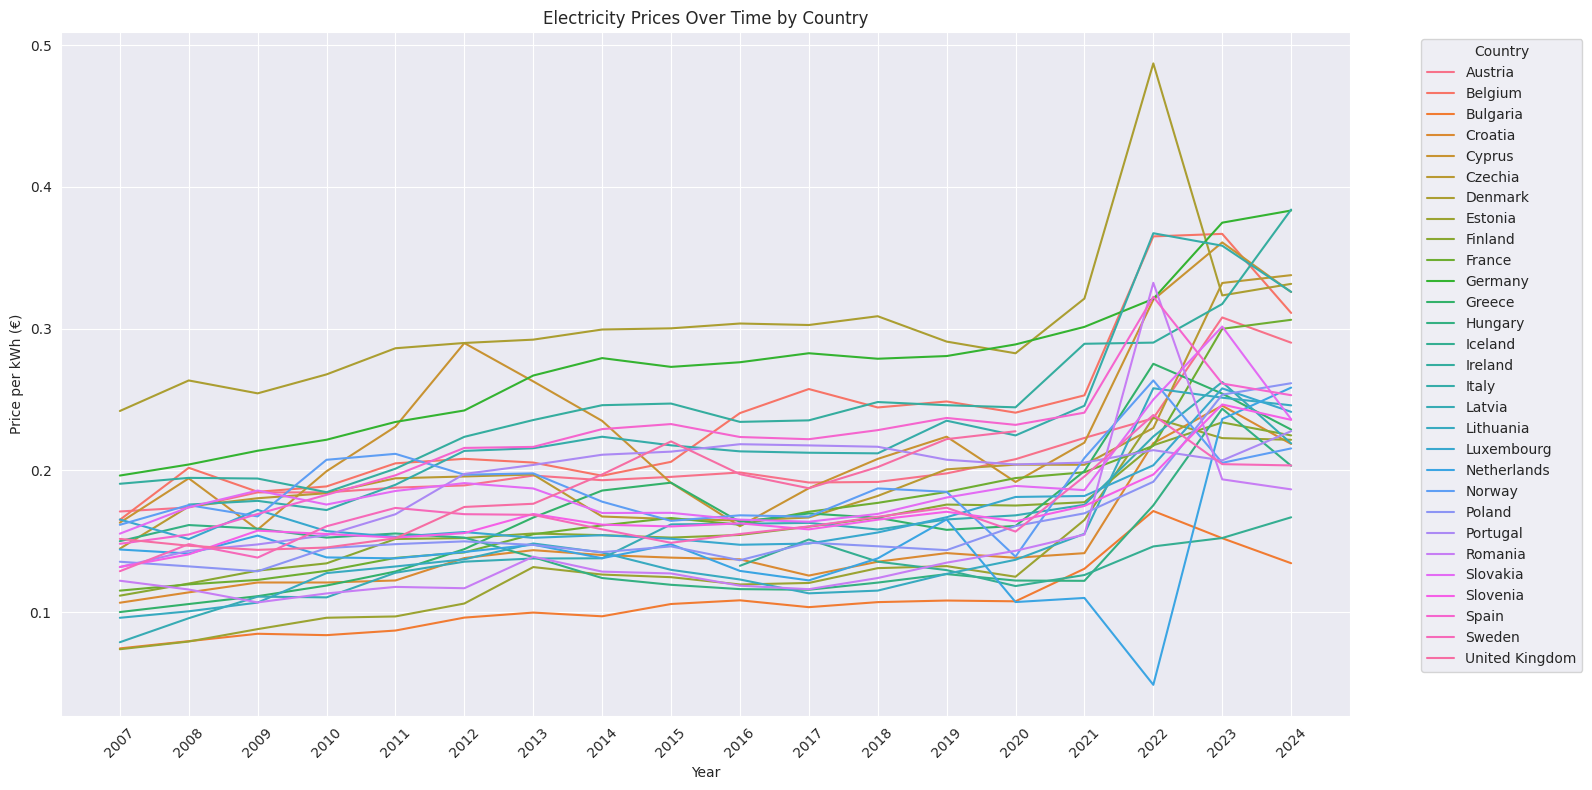

In [124]:
electricity_price_data_reset = electricity_price_data.reset_index()

# Create the plot
plt.figure(figsize=(16, 8))
sns.lineplot(x='Year', y='electricity price per kWh', hue='Entity', data=electricity_price_data_reset)

# Add labels and title
plt.title('Electricity Prices Over Time by Country')
plt.xlabel('Year')
plt.ylabel('Price per kWh (€)')
plt.xticks(rotation=45)

# Set the x-axis ticks to only show the years present in the dataset
years = sorted(electricity_price_data_reset['Year'].unique())
plt.xticks(ticks=years, labels=years)

# Adjust legend
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Interesting statistics and relations
## Relation between energy and electricity
Merge the share percentages into a single frame for easier plotting and data analysis


In [125]:
share_energy_electricity = pd.merge(
    share_energy,
    share_electricity,
    left_index=True,
    right_index=True,
    how='inner'
)

Additionally merge all our data into a single **mega-frame** for easier plotting/training

In [126]:
def construct_mega_frame(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    mega_df = dfs[0]

    for df in dfs[1:]:
        mega_df = pd.merge(
            mega_df,
            df,
            left_index=True,
            right_index=True,
            how='outer'
        )

    return mega_df

In [127]:
dfs = [share_energy_electricity, gdp_per_capita, energy_consumption_electricity_production, electricity_price_data]
mega_df = construct_mega_frame(dfs)
display(mega_df)

Hydro (% sub energy)  Solar (% sub energy)  \
Entity  Year                                               
Austria 1980                   NaN                   NaN   
        1981                   NaN                   NaN   
        1982                   NaN                   NaN   
        1983                   NaN                   NaN   
        1984                   NaN                   NaN   
...                            ...                   ...   
World   2016                 6.594                 0.539   
        2017                 6.515                 0.715   
        2018                 6.486                 0.896   
        2019                 6.481                 1.085   
        2020                 6.856                 1.365   

              Renewables (% sub energy)  Wind (% sub energy)  \
Entity  Year                                                   
Austria 1980                        NaN                  NaN   
        1981                        NaN                  NaN   
        1982                        NaN                  NaN   
        1983                        NaN                  NaN   
        1984                        NaN                  NaN   
...                                 ...                  ...   
World   2016                     10.239                1.579   
        2017                     10.618                1.827   
        2018                     10.978                1.972   
        2019                     11.437                2.174   
        2020                     12.553                2.539   

              Other Renewables (% sub energy)  Hydro (% electricity)  \
Entity  Year                                                           
Austria 1980                              NaN                    NaN   
        1981                              NaN                    NaN   
        1982                              NaN                    NaN   
        1983                              NaN                    NaN   
        1984                              NaN                    NaN   
...                                       ...                    ...   
World   2016                            1.527                 16.531   
        2017                            1.561                 16.277   
        2018                            1.624                 16.129   
        2019                            1.697                 16.048   
        2020                            1.793                 16.516   

              Wind (% electricity)  Solar (% electricity)  \
Entity  Year                                                
Austria 1980                   NaN                    NaN   
        1981                   NaN                    NaN   
        1982                   NaN                    NaN   
        1983                   NaN                    NaN   
        1984                   NaN                    NaN   
...                            ...                    ...   
World   2016                 3.965                  1.358   
        2017                 4.570                  1.782   
        2018                 4.906                  2.196   
        2019                 5.401                  2.642   
        2020                 6.079                  3.197   

              Renewables (% electricity)  Other Renewables (% electricity)  \
Entity  Year                                                                 
Austria 1980                         NaN                               NaN   
        1981                         NaN                               NaN   
        1982                         NaN                               NaN   
        1983                         NaN                               NaN   
        1984                         NaN                               NaN   
...                                  ...                               ...   
World   2016                      24.256     

### Visualizations
First we look at the energy-electricity gap (The difference between energy and electricity adoption). Let's plot the countries with the largest gap.

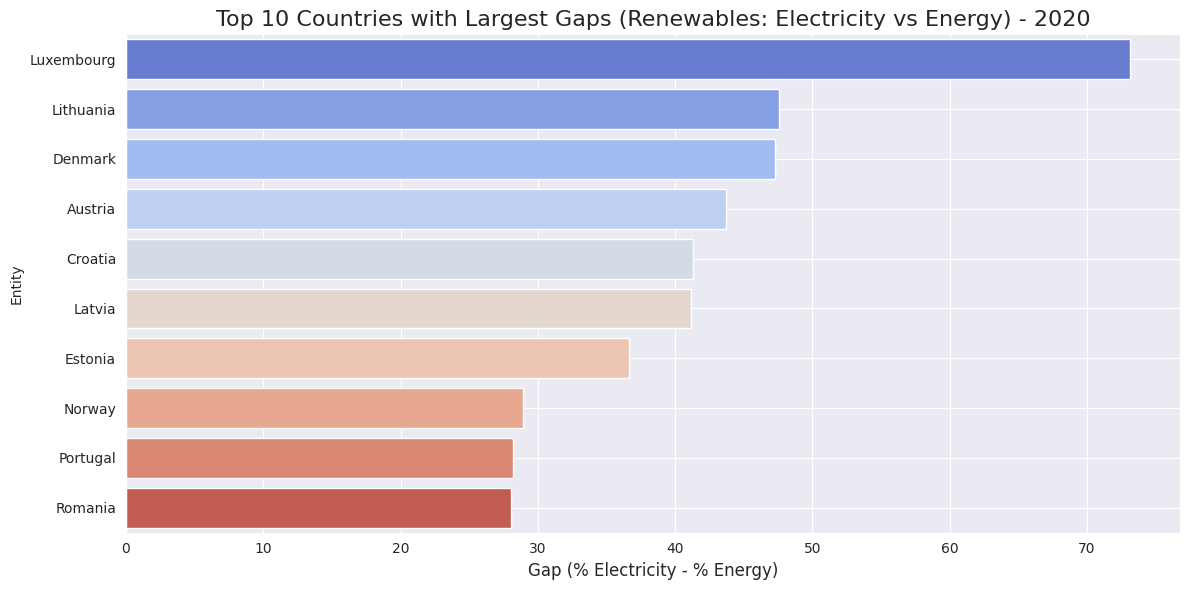

In [128]:
# Filter for the year 2020
data_2020 = share_energy_electricity.xs(key=2020, level='Year').copy()  # Use `.copy()` to avoid the warning

# Calculate the gap between Renewable Electricity and Renewable Energy
data_2020.loc[:, 'Gap'] = data_2020['Renewables (% electricity)'] - data_2020['Renewables (% sub energy)']

# Sort by the largest gap
largest_gaps = data_2020[['Gap']].sort_values(by='Gap', ascending=False).reset_index()

# Bar plot for the largest gaps in 2020
plt.figure(figsize=(12, 6))
sns.barplot(data=largest_gaps.head(10), x='Gap', y='Entity', palette='coolwarm', hue='Entity', dodge=False, legend=False)
plt.title('Top 10 Countries with Largest Gaps (Renewables: Electricity vs Energy) - 2020', fontsize=16)
plt.xlabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Let's compare Austria to the rest of europe.

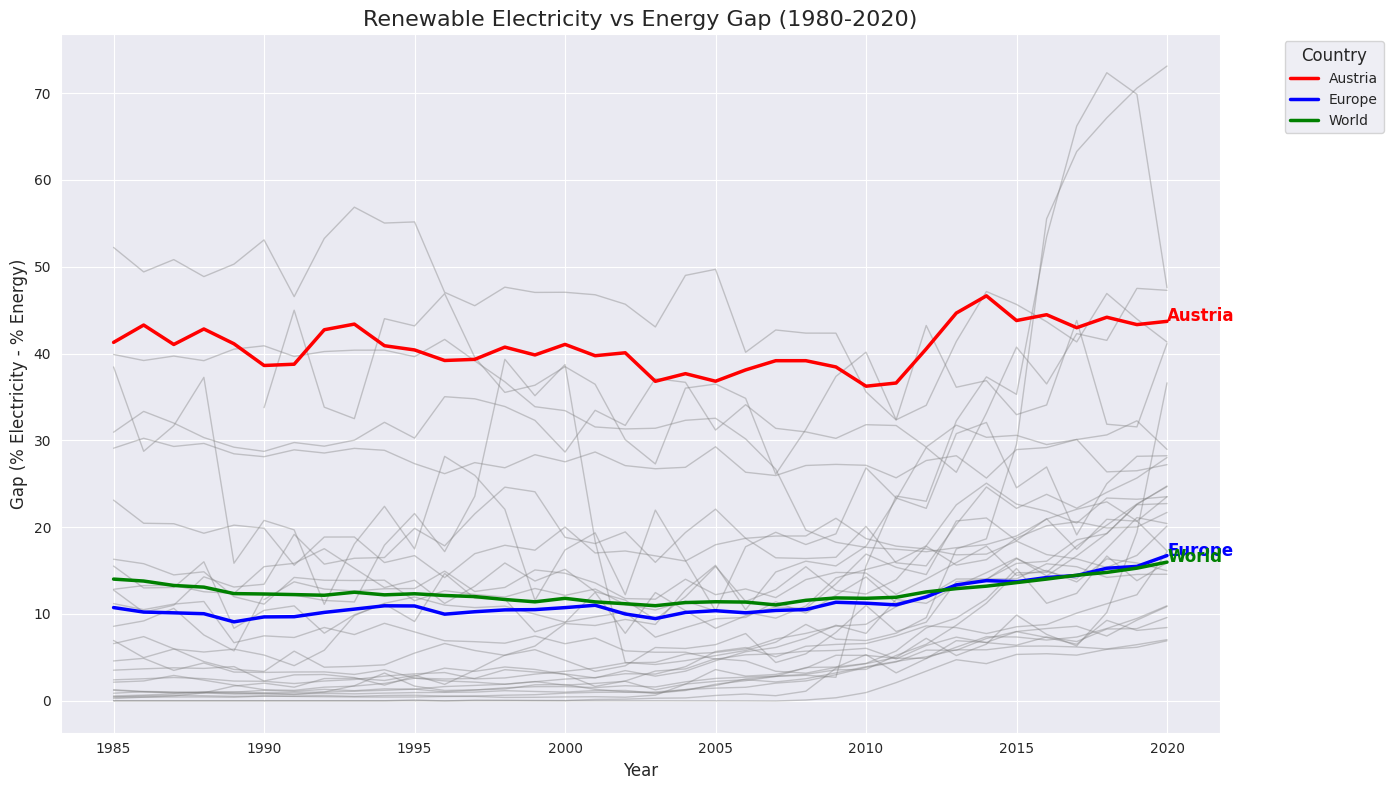

In [129]:
# Filter for the last 10 years (2011–2020)
energy_electricity_long = share_energy_electricity.copy()

# Calculate the gap for each country and year
energy_electricity_long.loc[:, 'Gap'] = energy_electricity_long['Renewables (% electricity)'] - energy_electricity_long['Renewables (% sub energy)']

# Reset index for plotting
gap_over_time = energy_electricity_long.reset_index()

# Define standout countries
standout_countries = ['Austria', 'Europe', 'World']

# Create a custom color palette
palette = {country: 'gray' for country in gap_over_time['Entity'].unique()}
palette.update({
    'Austria': 'red',
    'Europe': 'blue',
    'World': 'green'
})

plt.figure(figsize=(14, 8))

# Plot all countries with lighter lines
sns.lineplot(
    data=gap_over_time[~gap_over_time['Entity'].isin(standout_countries)],
    x='Year', y='Gap', hue='Entity', palette=palette, alpha=0.4, linewidth=1, legend=False
)

# Plot standout countries with distinctive styles
sns.lineplot(
    data=gap_over_time[gap_over_time['Entity'].isin(standout_countries)],
    x='Year', y='Gap', hue='Entity', palette=palette, linewidth=2.5
)

# Add labels and title
plt.title(f'Renewable Electricity vs Energy Gap ({time_window[0]}-{time_window[1]})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.legend(title='Country', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)

# Highlight standout countries with direct annotations
for country in standout_countries:
    country_data = gap_over_time[gap_over_time['Entity'] == country]
    plt.text(
        country_data['Year'].iloc[-1],
        country_data['Gap'].iloc[-1],
        country,
        color=palette[country], fontsize=12, weight='bold'
    )

plt.tight_layout()
plt.show()


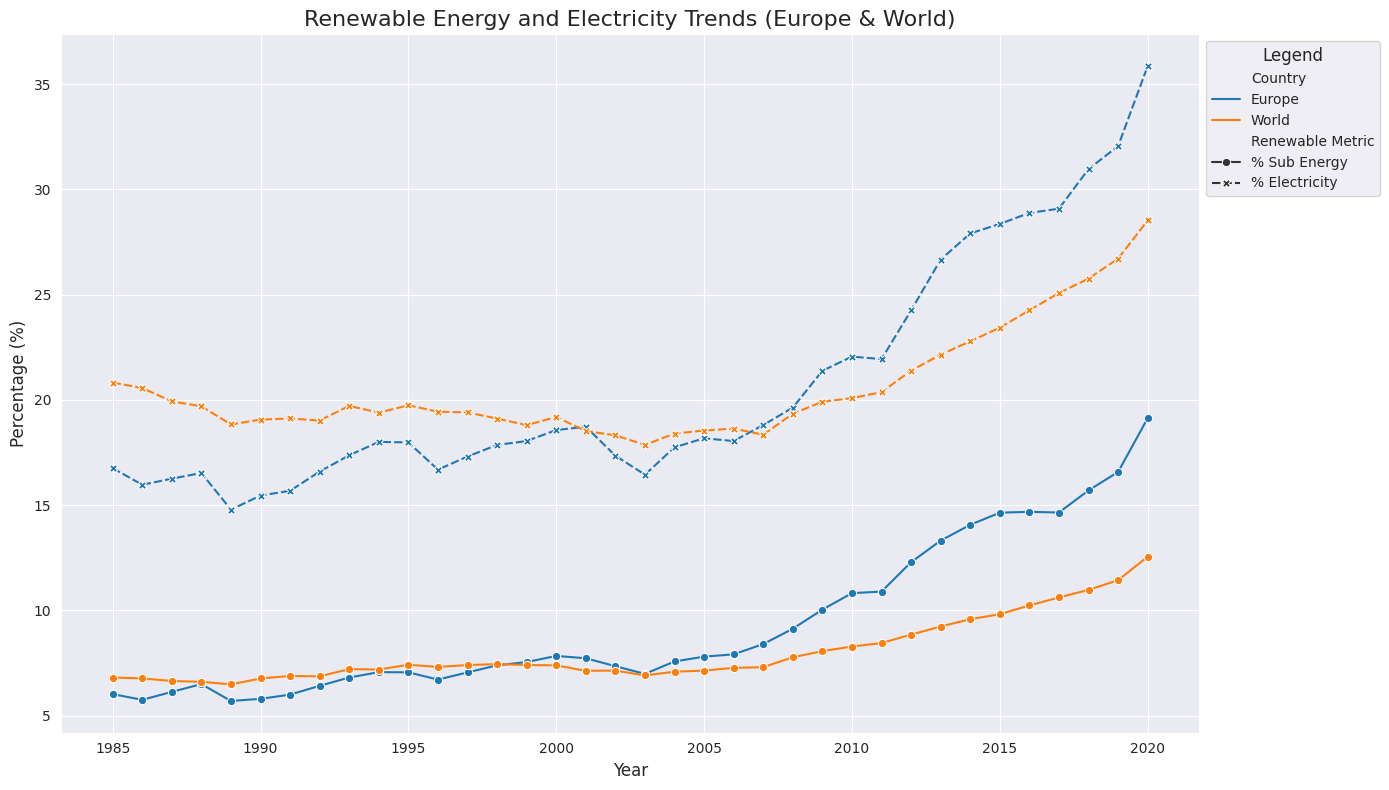

In [130]:
# Define europe_world (if not already defined)
europe_world = share_energy_electricity.loc[
    share_energy_electricity.index.get_level_values('Entity').isin(['Europe', 'World'])
].reset_index()

europe_world.rename(columns={'Entity': 'Country'}, inplace=True)

# Reshape the data to combine 'Renewables (% sub energy)' and 'Renewables (% electricity)' into one column
europe_world_melted = europe_world.melt(
    id_vars=['Year', 'Country'],
    value_vars=['Renewables (% sub energy)', 'Renewables (% electricity)'],
    var_name='Renewable Metric',
    value_name='Percentage'
)

# Rename metrics for better readability
europe_world_melted['Renewable Metric'] = europe_world_melted['Renewable Metric'].replace({
    'Renewables (% sub energy)': '% Sub Energy',
    'Renewables (% electricity)': '% Electricity'
})

# Create a line plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=europe_world_melted,
    x='Year',
    y='Percentage',
    hue='Country',
    style='Renewable Metric',  # Different styles for sub energy vs electricity
    markers=True,
    dashes=True,
    palette='tab10'
)

# Add plot titles and labels
plt.title('Renewable Energy and Electricity Trends (Europe & World)', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Customize the legend for clarity
plt.legend(title='Legend', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Dependency on weather data

Fetching weather data for Austria...
Fetching weather data for Belgium...
Fetching weather data for Bulgaria...
Fetching weather data for Croatia...
Fetching weather data for Cyprus...
Fetching weather data for Czechia...
Fetching weather data for Denmark...
Fetching weather data for Estonia...
Fetching weather data for Finland...
Fetching weather data for France...
Fetching weather data for Germany...
Fetching weather data for Greece...
Fetching weather data for Hungary...
Fetching weather data for Iceland...
Fetching weather data for Ireland...
Fetching weather data for Italy...
Fetching weather data for Latvia...
Fetching weather data for Lithuania...
Fetching weather data for Luxembourg...
Fetching weather data for Malta...
Fetching weather data for Netherlands...
Fetching weather data for Norway...
Fetching weather data for Poland...
Fetching weather data for Portugal...
Fetching weather data for Romania...
Fetching weather data for Slovakia...
Fetching weather data for Slovenia..

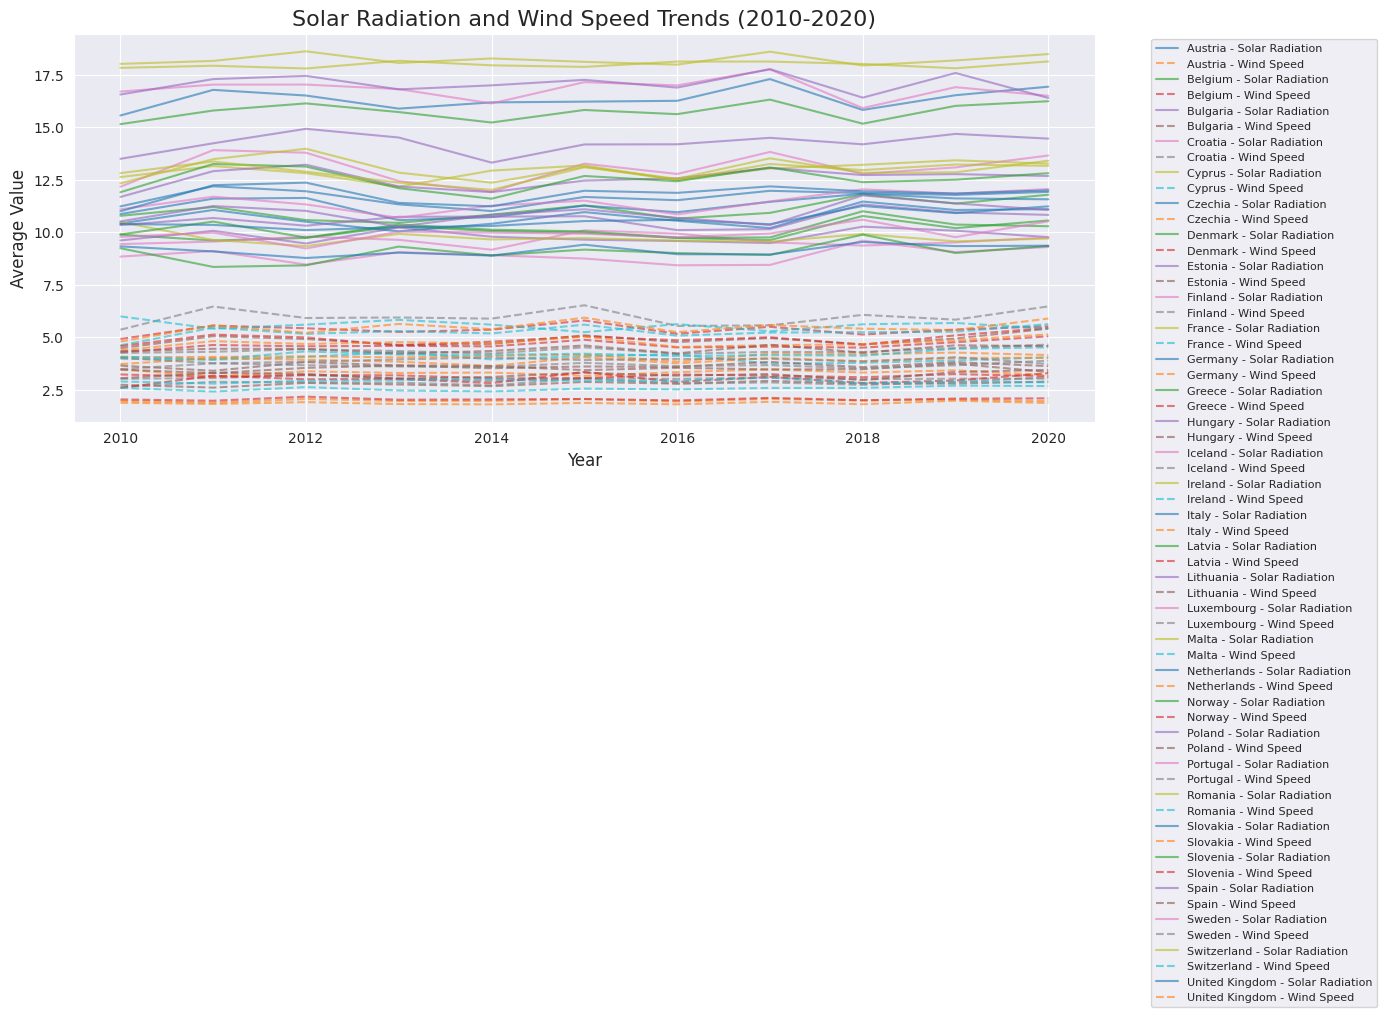

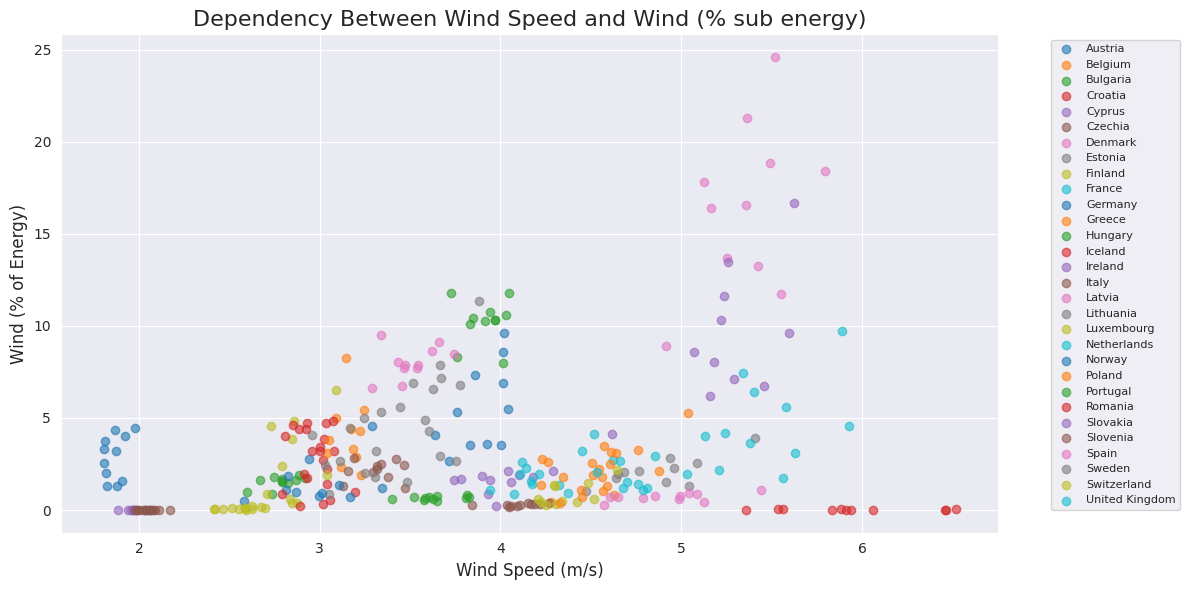

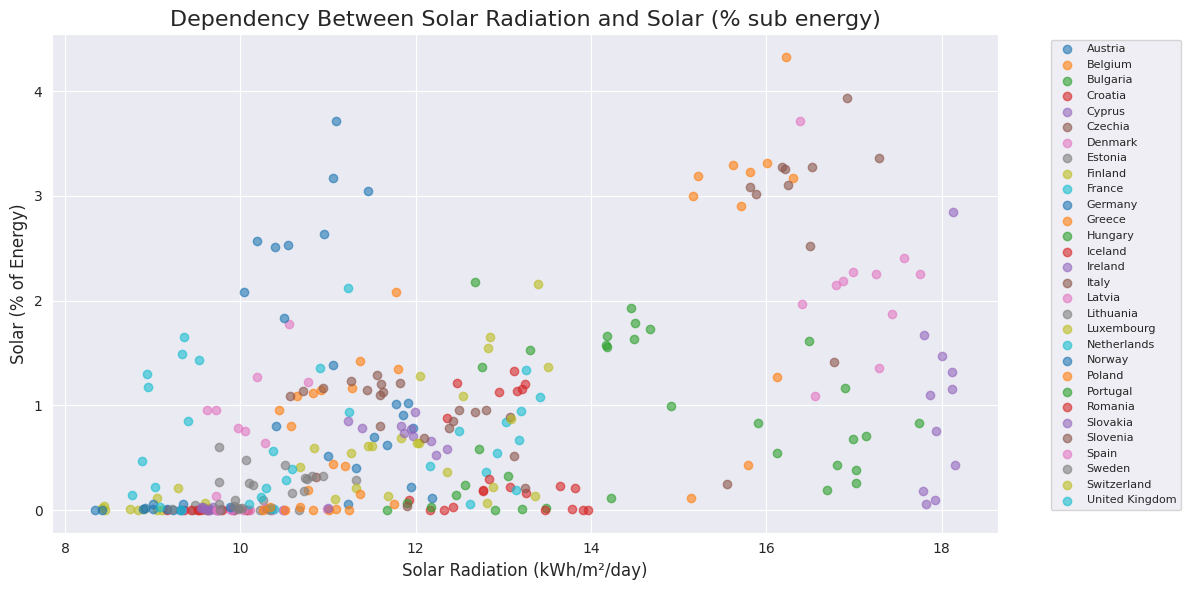

In [131]:
import requests

# List of European countries
european_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
    'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands',
    'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
    'Sweden', 'Switzerland', 'United Kingdom'
]

# Function to fetch weather data
def fetch_weather_data(lat, lon, start_year, end_year):
    """Fetch daily solar radiation and wind speed data from NASA POWER API."""
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "ALLSKY_SFC_SW_DWN,WS10M",
        "community": "AG",
        "longitude": lon,
        "latitude": lat,
        "start": f"{start_year}0101",
        "end": f"{end_year}1231",
        "format": "JSON",
        "header": "true",
        "time-standard": "UTC"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json()

# Dictionary of country coordinates (add exact latitude and longitude for each country)
country_coordinates = {
    'Austria': (47.5162, 14.5501),
    'Belgium': (50.8503, 4.3517),
    'Bulgaria': (42.7339, 25.4858),
    'Croatia': (45.1, 15.2),
    'Cyprus': (35.1264, 33.4299),
    'Czechia': (49.8175, 15.473),
    'Denmark': (56.2639, 9.5018),
    'Estonia': (58.5953, 25.0136),
    'Finland': (61.9241, 25.7482),
    'France': (46.6034, 1.8883),
    'Germany': (51.1657, 10.4515),
    'Greece': (39.0742, 21.8243),
    'Hungary': (47.1625, 19.5033),
    'Iceland': (64.9631, -19.0208),
    'Ireland': (53.4129, -8.2439),
    'Italy': (41.8719, 12.5674),
    'Latvia': (56.8796, 24.6032),
    'Lithuania': (55.1694, 23.8813),
    'Luxembourg': (49.8153, 6.1296),
    'Malta': (35.9375, 14.3754),
    'Netherlands': (52.1326, 5.2913),
    'Norway': (60.4720, 8.4689),
    'Poland': (51.9194, 19.1451),
    'Portugal': (39.3999, -8.2245),
    'Romania': (45.9432, 24.9668),
    'Slovakia': (48.6690, 19.6990),
    'Slovenia': (46.1512, 14.9955),
    'Spain': (40.4637, -3.7492),
    'Sweden': (60.1282, 18.6435),
    'Switzerland': (46.8182, 8.2275),
    'United Kingdom': (55.3781, -3.4360)
}

# Fetch weather data for each country
time_window_weather = (2010, 2020)
weather_data = {}

file_path ='api_data.pkl'
cached_api_data = {}
if os.path.exists(file_path):
    with open(file_path, 'rb') as file:  # Use "rb" mode to read in binary format
        cached_api_data = pickle.load(file)

for country, (lat, lon) in country_coordinates.items():
    print(f"Fetching weather data for {country}...")
    try:
        key = (lat, lon)
        if key not in cached_api_data:
            cached_api_data[key] = fetch_weather_data(key[0], key[1], time_window_weather[0], time_window_weather[1])

        data = cached_api_data[key]
        daily_data = data['properties']['parameter']
        df = pd.DataFrame({
            'Date': pd.to_datetime(list(daily_data['ALLSKY_SFC_SW_DWN'].keys())),
            'Solar Radiation': list(daily_data['ALLSKY_SFC_SW_DWN'].values()),
            'Wind Speed': list(daily_data['WS10M'].values())
        })
        df['Year'] = df['Date'].dt.year
        yearly_data = df.groupby('Year')[['Solar Radiation', 'Wind Speed']].mean().reset_index()
        weather_data[country] = yearly_data
    except Exception as e:
        print(f"Failed to fetch weather data for {country}: {e}")

# save cached weather data
with open(file_path, 'wb') as file:
    pickle.dump(cached_api_data, file)

# Extract power data from `share_energy`
power_data = pd.DataFrame()
for country in european_countries:
    if country in share_energy.index.get_level_values('Entity'):
        country_power_data = share_energy.loc[country].reset_index()
        country_power_data['Country'] = country
        power_data = pd.concat([power_data, country_power_data])

# Combine weather and power data
combined_data = pd.DataFrame()
for country, weather_df in weather_data.items():
    power_df = power_data[power_data['Country'] == country]
    combined = weather_df.merge(power_df, on='Year', how='inner')
    combined['Country'] = country
    combined_data = pd.concat([combined_data, combined])

# First Plot: Solar Radiation and Wind Speed Trends
plt.figure(figsize=(14, 8))
for country, data in weather_data.items():
    plt.plot(data['Year'], data['Solar Radiation'], label=f"{country} - Solar Radiation", linestyle='-', alpha=0.6)
    plt.plot(data['Year'], data['Wind Speed'], label=f"{country} - Wind Speed", linestyle='--', alpha=0.6)

plt.title('Solar Radiation and Wind Speed Trends (2010-2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot 1: Wind Speed vs Wind (% sub energy)
plt.figure(figsize=(12, 6))
for country in combined_data['Country'].unique():
    country_data = combined_data[combined_data['Country'] == country]
    plt.scatter(country_data['Wind Speed'], country_data['Wind (% sub energy)'], label=country, alpha=0.6)

plt.title('Dependency Between Wind Speed and Wind (% sub energy)', fontsize=16)
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Wind (% of Energy)', fontsize=12)
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot 2: Solar Radiation vs Solar (% sub energy)
plt.figure(figsize=(12, 6))
for country in combined_data['Country'].unique():
    country_data = combined_data[combined_data['Country'] == country]
    plt.scatter(country_data['Solar Radiation'], country_data['Solar (% sub energy)'], label=country, alpha=0.6)

plt.title('Dependency Between Solar Radiation and Solar (% sub energy)', fontsize=16)
plt.xlabel('Solar Radiation (kWh/m²/day)', fontsize=12)
plt.ylabel('Solar (% of Energy)', fontsize=12)
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Calculate European averages for each year

In [132]:
european_averages = combined_data.groupby('Year').agg({
    'Wind Speed': 'mean',
    'Wind (% sub energy)': 'mean',
    'Solar Radiation': 'mean',
    'Solar (% sub energy)': 'mean'
}).reset_index()

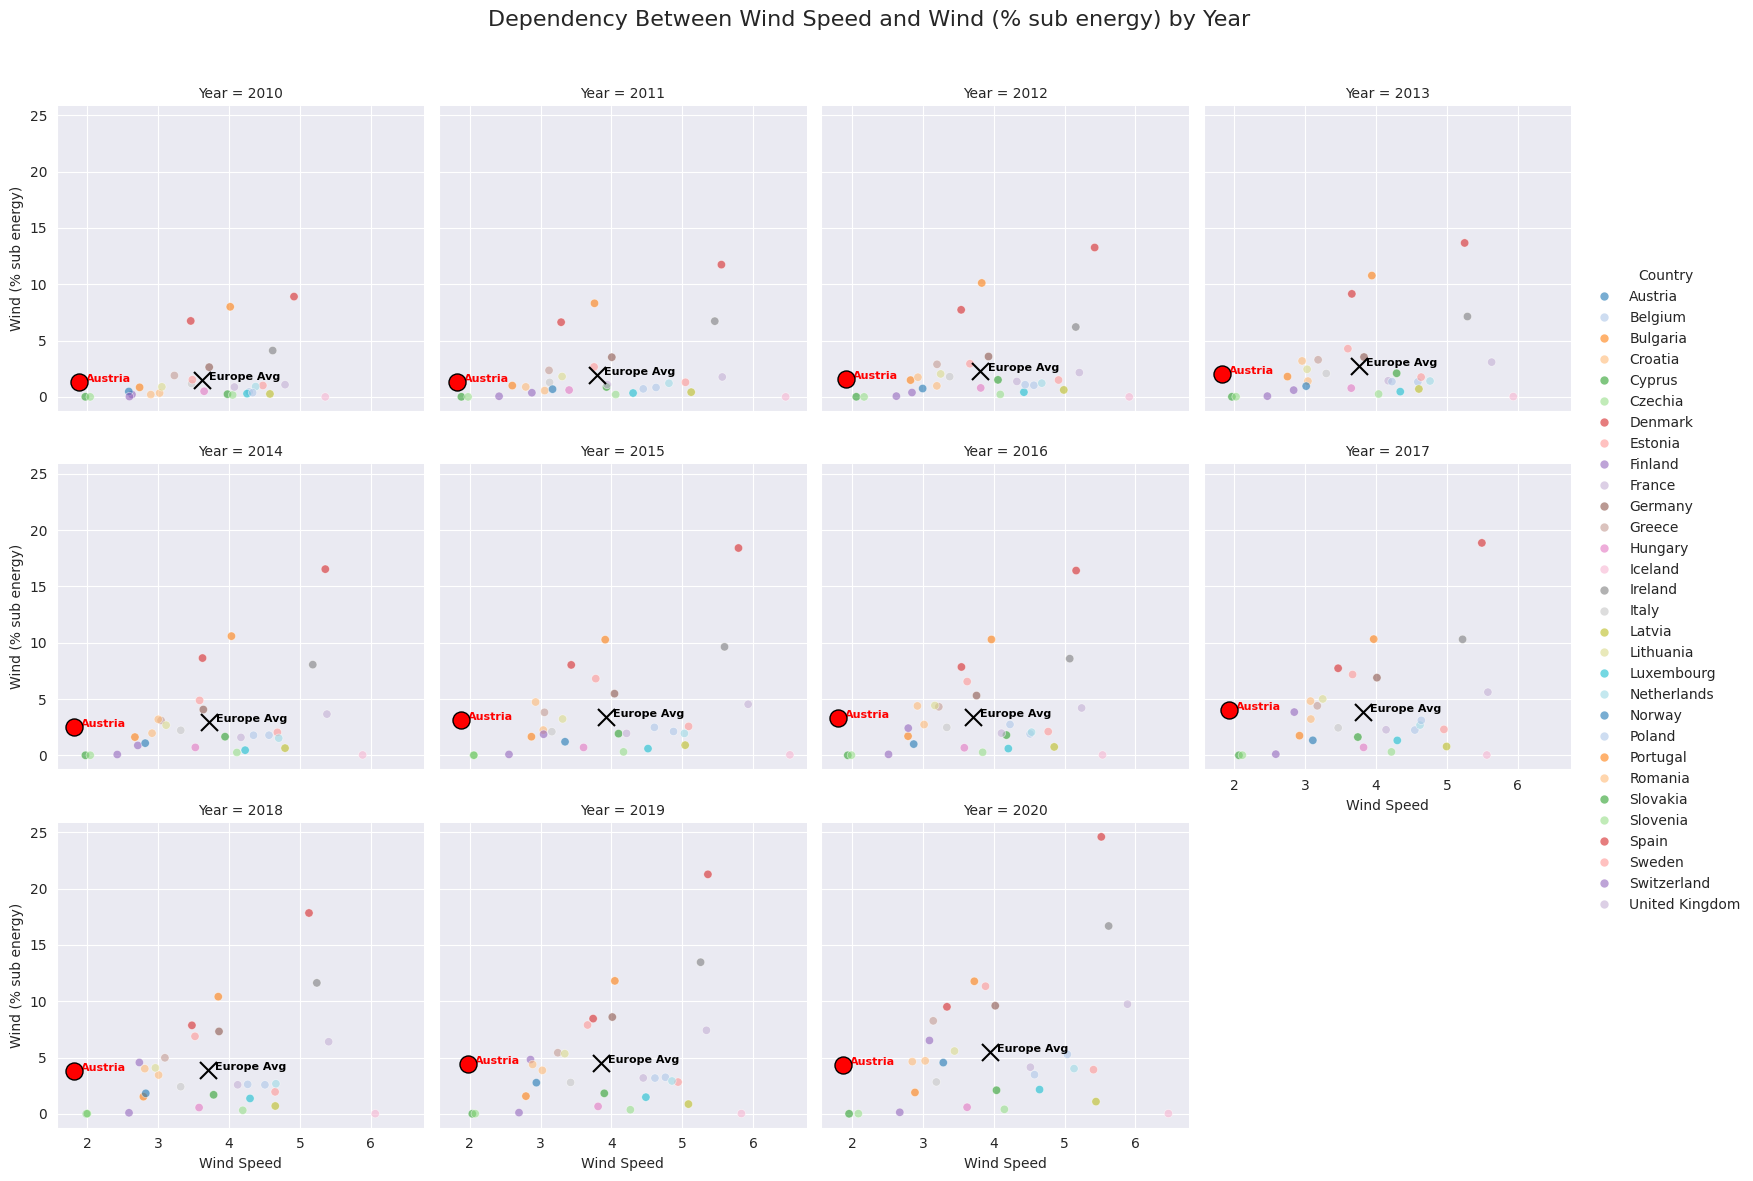

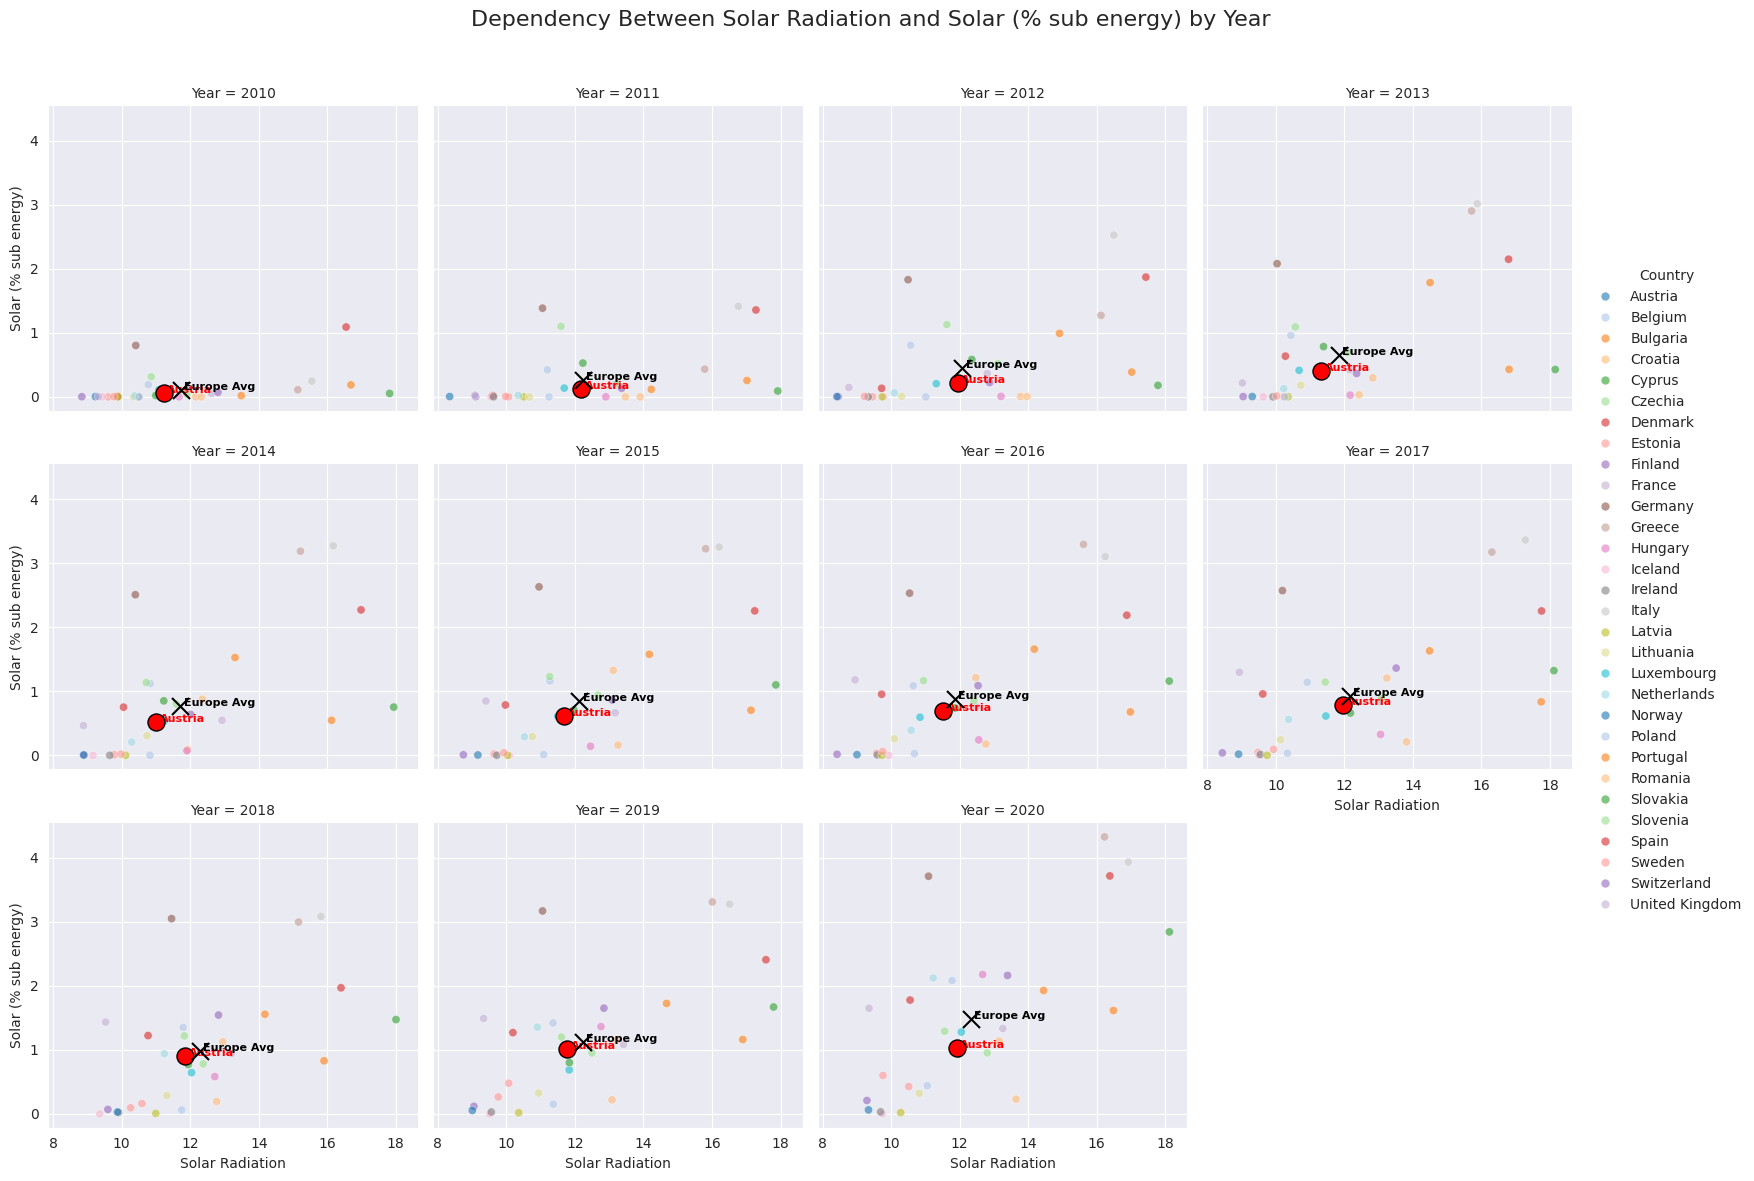

In [133]:
# Scatter plot for wind speed vs. wind contribution
g = sns.relplot(
    data=combined_data,
    x='Wind Speed',
    y='Wind (% sub energy)',
    col='Year',
    kind='scatter',
    col_wrap=4,
    height=4,
    alpha=0.6,
    hue='Country',
    palette='tab20',
    legend='brief'  # Automatic legend for countries
)

# Highlight Austria and add European averages with labels
for ax, year in zip(g.axes.flat, combined_data['Year'].unique()):
    # Highlight Austria
    austria_data = combined_data[(combined_data['Country'] == 'Austria') & (combined_data['Year'] == year)]
    if not austria_data.empty:
        ax.scatter(
            austria_data['Wind Speed'], austria_data['Wind (% sub energy)'],
            color='red', s=150, edgecolor='black', zorder=5  # Highlight Austria
        )
        # Add label for Austria
        ax.text(
            austria_data['Wind Speed'].values[0] + 0.1,
            austria_data['Wind (% sub energy)'].values[0],
            'Austria', color='red', fontsize=8, weight='bold'
        )
    # Add European average
    avg_data = european_averages[european_averages['Year'] == year]
    if not avg_data.empty:
        ax.scatter(
            avg_data['Wind Speed'], avg_data['Wind (% sub energy)'],
            color='black', s=150, marker='x', zorder=6  # Highlight European average
        )
        # Add label for European average
        ax.text(
            avg_data['Wind Speed'].values[0] + 0.1,
            avg_data['Wind (% sub energy)'].values[0],
            'Europe Avg', color='black', fontsize=8, weight='bold'
        )

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Dependency Between Wind Speed and Wind (% sub energy) by Year', fontsize=16)
plt.show()

# Scatter plot for solar radiation vs. solar contribution
g = sns.relplot(
    data=combined_data,
    x='Solar Radiation',
    y='Solar (% sub energy)',
    col='Year',
    kind='scatter',
    col_wrap=4,
    height=4,
    alpha=0.6,
    hue='Country',
    palette='tab20',
    legend='brief'  # Automatic legend for countries
)

# Highlight Austria and add European averages with labels
for ax, year in zip(g.axes.flat, combined_data['Year'].unique()):
    # Highlight Austria
    austria_data = combined_data[(combined_data['Country'] == 'Austria') & (combined_data['Year'] == year)]
    if not austria_data.empty:
        ax.scatter(
            austria_data['Solar Radiation'], austria_data['Solar (% sub energy)'],
            color='red', s=150, edgecolor='black', zorder=5  # Highlight Austria
        )
        # Add label for Austria
        ax.text(
            austria_data['Solar Radiation'].values[0] + 0.1,
            austria_data['Solar (% sub energy)'].values[0],
            'Austria', color='red', fontsize=8, weight='bold'
        )
    # Add European average
    avg_data = european_averages[european_averages['Year'] == year]
    if not avg_data.empty:
        ax.scatter(
            avg_data['Solar Radiation'], avg_data['Solar (% sub energy)'],
            color='black', s=150, marker='x', zorder=6  # Highlight European average
        )
        # Add label for European average
        ax.text(
            avg_data['Solar Radiation'].values[0] + 0.1,
            avg_data['Solar (% sub energy)'].values[0],
            'Europe Avg', color='black', fontsize=8, weight='bold'
        )

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Dependency Between Solar Radiation and Solar (% sub energy) by Year', fontsize=16)
plt.show()

# Predictions for the future

     Entity       Year  Hydro (% sub energy)  Solar (% sub energy)  \
376  Europe 1980-01-01                   NaN                   NaN   
377  Europe 1981-01-01                   NaN                   NaN   
378  Europe 1982-01-01                   NaN                   NaN   
379  Europe 1983-01-01                   NaN                   NaN   
380  Europe 1984-01-01                   NaN                   NaN   
381  Europe 1985-01-01                 5.897                 0.000   
382  Europe 1986-01-01                 5.605                 0.000   
383  Europe 1987-01-01                 5.984                 0.000   
384  Europe 1988-01-01                 6.347                 0.000   
385  Europe 1989-01-01                 5.543                 0.000   
386  Europe 1990-01-01                 5.582                 0.000   
387  Europe 1991-01-01                 5.772                 0.000   
388  Europe 1992-01-01                 6.161                 0.000   
389  Europe 1993-01-

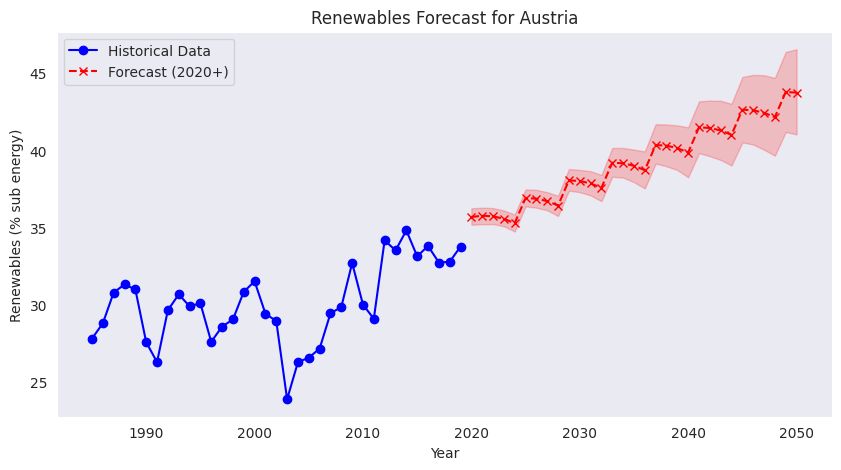

Processing forecast for Iceland


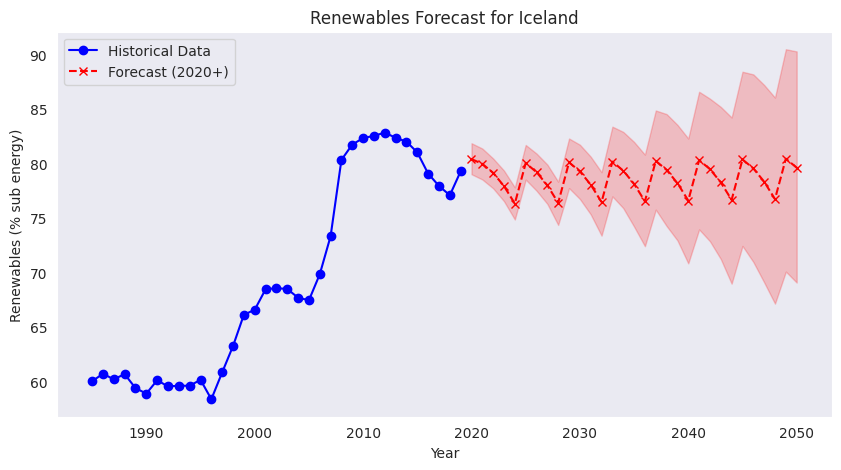

Processing forecast for Romania


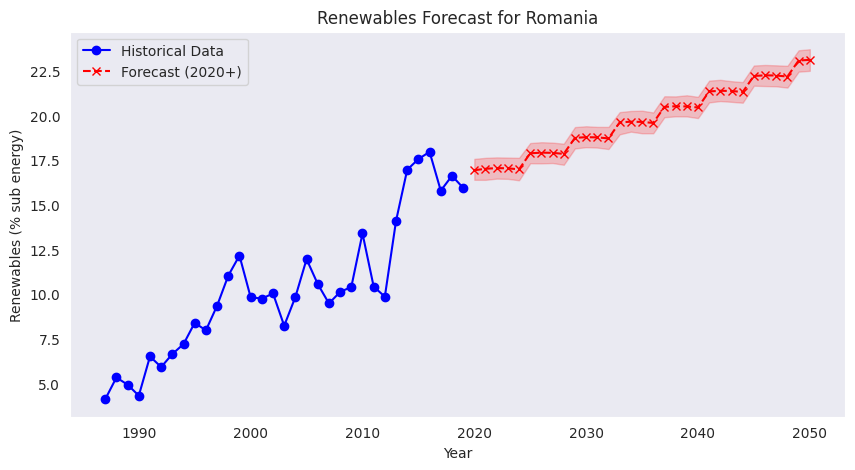

Forecasting complete and saved to 'prophet_country_renewables_forecast_with_regressors.csv'


/tmp/ipykernel_290439/249820865.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  forecast_results = grouped.apply(lambda group: forecast_country(group))


In [134]:
import pandas as pd
from prophet import Prophet
import logging
import warnings

logging.getLogger("cmdstanpy").disabled = True
warnings.filterwarnings("ignore", message="'Y' is deprecated and will be removed")


df = mega_df.reset_index().copy()

df['Year'] = pd.to_datetime(df['Year'], format='%Y')

selected_columns = [
    'Renewables (% sub energy)',
    'GDP per capita (USD)',
    'Electricity production wind (TWh)',
    'Electricity production hydro (TWh)',
    'Solar consumption (TWh)',
    'Renewables (% electricity)'
]

standout_countries = ['Austria', 'Romania', 'Iceland', 'Europe']
print(df[df['Entity'] == 'Europe'])
df = df[['Entity', 'Year'] + selected_columns].dropna()
df = df[df['Entity'].isin(standout_countries)]

def plot_forecast(group, forecast):
    country_name = group['Entity'].iloc[0]

    # Split data into historical (before 2020) and forecast (from 2020)
    historical_data = group[group['Year'] < '2020']
    forecast_data = forecast[forecast['ds'] >= '2020']

    plt.figure(figsize=(10, 5))

    # Plot historical data (actual observations)
    plt.plot(historical_data['Year'], historical_data['Renewables (% sub energy)'], label='Historical Data', marker='o', color='blue')

    # Plot forecast data
    plt.plot(forecast_data['ds'], forecast_data['yhat'], label='Forecast (2020+)', marker='x', linestyle='--', color='red')

    # Confidence interval shading
    plt.fill_between(forecast_data['ds'], forecast_data['yhat_lower'], forecast_data['yhat_upper'], color='red', alpha=0.2)

    # Formatting the plot
    plt.title(f"Renewables Forecast for {country_name}")
    plt.xlabel('Year')
    plt.ylabel('Renewables (% sub energy)')
    plt.legend()
    plt.grid()
    plt.show()

def forecast_country(group):
    print(f"Processing forecast for {group['Entity'].iloc[0]}")

    prophet_df = group[['Year', 'Renewables (% sub energy)',
                        'GDP per capita (USD)',
                        'Electricity production wind (TWh)',
                        'Electricity production hydro (TWh)',
                        'Solar consumption (TWh)',
                        'Renewables (% electricity)']].dropna()

    prophet_df.rename(columns={'Year': 'ds', 'Renewables (% sub energy)': 'y'}, inplace=True)

    model = Prophet()
    model.add_regressor('GDP per capita (USD)')
    model.add_regressor('Electricity production wind (TWh)')
    model.add_regressor('Electricity production hydro (TWh)')
    model.add_regressor('Solar consumption (TWh)')
    model.add_regressor('Renewables (% electricity)')

    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=30, freq='Y')
    for col in selected_columns[1:]:
        future[col] = prophet_df[col].iloc[-1]

    forecast = model.predict(future)

    plot_forecast(group, forecast)

    forecast['Entity'] = group['Entity'].iloc[0]
    return forecast[['Entity', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']]

grouped = df.groupby('Entity')
forecast_results = grouped.apply(lambda group: forecast_country(group))

print("Forecasting complete and saved to 'prophet_country_renewables_forecast_with_regressors.csv'")
